In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import seaborn as sns
pd.set_option('display.max_colwidth', None) 

# Read and preprocess data

In [2]:
df = pd.read_excel('./clips - interest points.xlsx',sheet_name='Sheet1',header=0)
print(len(df))
df.head()

200


,Ticket,Category,Name,Recording method,Frame
0,NGC3D-258315,screen slide,FM,Camera,NaN
1,CCS2BUG-586,frame error,AA connected phone receive message,Capture/Emulator,"93,278,489"
2,NCG3D-263526,list - slider,Half Turn List (2),Camera,NaN
3,NCG3D-226483,screen slide,swipe left,Camera,NaN
4,NCG3D-281808,chaotic switch,connect iphone,Camera,NaN


In [16]:
# for i in range(len(df)):
#     if not pd.isna(df.loc[i,'Frame']):
#         lst = split_csv(df.loc[i,'Frame'])
#         for j in range(len(lst)):
#             lst[j] = lst[j] - 10
#             if lst[j] < 0:
#                 lst[j] = 0
                
#         line = str(lst[0])
#         for item in lst[1:]:
#             line += ',' + str(item)
#         df.loc[i,'Frame'] = line

# df.to_excel('clips - interest points.xlsx',index=False)

In [3]:
for i in range(len(df)):
    if pd.isna(df.loc[i,'Frame']) or df.loc[i,'Category'] != 'frame error' or df.loc[i,'Recording method'] != 'Capture/Emulator':
        df.drop(labels=i,axis=0,inplace=True)

print(len(df))
df = df.reset_index(drop = True)
df.drop(columns=['Ticket','Category','Recording method'],axis=1,inplace=True)
df.head()

42


,Name,Frame
0,AA connected phone receive message,"93,278,489"
1,AM-FM CP AM-FM,"100,167,218,269,317,364,404,447,489,539,590,634,909,1131,1370"
2,black screen when trigger Siri,"538,844"
3,clock issue,"17,74,196,238,563,706"
4,connect CP then connect AA,"370,528,533,736,743"


In [4]:
def split_csv(str):
    answer = []
    for number in str.split(','):
        answer.append(int(number))
    return answer

In [5]:
from scenedetect import detect, ContentDetector, AdaptiveDetector
from datetime import datetime, timedelta

In [6]:
def detectAsFlicker(current_time,old_time):
    minimum_between_cuts = timedelta(milliseconds=400)
    return (datetime.strptime(current_time, '%H:%M:%S.%f') - datetime.strptime(old_time, '%H:%M:%S.%f')) <= minimum_between_cuts

In [22]:
CUSTOM_COMPONENTS = ContentDetector.Components(
            delta_hue = 0.5,
            delta_sat = 1.0,
            delta_lum = 0.5,
            delta_edges = 1,
        )

In [7]:
def create_csv_string_from_list(lst):
    if len(lst) == 0:
        return ''
    result = str(lst[0])
    for item in lst[1:]:
        result += ',' + str(item)
    return result

In [130]:
score_df = pd.DataFrame(columns=['th','delta_sat','TP','FP','FN'])

CUSTOM_COMPONENTS = ContentDetector.Components(
    delta_hue = 1,
    delta_sat = 2,
    delta_lum = 1,
    delta_edges = 1.5,
)

for th in tqdm(range(10,25,3)):
    for w in range(2,11,4):
        count_tp = 0
        count_fp = 0
        count_fn = 0
        
        for root, dirs, files in os.walk('./clips/'):
            video_name = root.split('/')[-1]
            if video_name in df['Name'].values:
                flicker_clips = split_csv(df.loc[df['Name'] == video_name]['Frame'].values[0])
                for file in files:
                    old_time = '00:00:00.000'
                    scene_list = detect(os.path.join(root,file),
                                        AdaptiveDetector(adaptive_threshold=2.7,min_content_val=th,window_width=w,weights=CUSTOM_COMPONENTS,min_scene_len=1))
                
                    for i, scene in enumerate(scene_list[1:-1]):
                        if detectAsFlicker(scene[1].get_timecode(),scene[0].get_timecode()):
                            clip_index = int(file.split(' ')[0])
                            if clip_index in flicker_clips:
                                flicker_clips.remove(clip_index)
                                count_tp += 1
                            else:
                                count_fp += 1
                            break
                count_fn += len(flicker_clips)
        
        newrow = {'adaptive_th': ath, 'delta_sat': delta_sat, 'TP': count_tp, 'FP': count_fp, 'FN': count_fn}
        score_df = score_df.append(newrow, ignore_index = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [13:06<00:00, 157.31s/it]


In [19]:
fp_df = pd.DataFrame(columns=['Name','FP'])
#ContentDetector(th=20) 1 2 1 1.5
CUSTOM_COMPONENTS = ContentDetector.Components(
    delta_hue = 0.5,
    delta_sat = 1,
    delta_lum = 0.5,
    delta_edges = 1.5,
)

count_tp = 0
count_fp = 0
count_fn = 0

for root, dirs, files in os.walk('./clips/'):
    video_name = root.split('/')[-1]
    if video_name in df['Name'].values:
        flicker_clips = split_csv(df.loc[df['Name'] == video_name]['Frame'].values[0])
        fp_list = []
        for file in files:
            old_time = '00:00:00.000'
            scene_list = detect(os.path.join(root,file), AdaptiveDetector(adaptive_threshold=2.5,min_content_val=25,window_width=4,weights=CUSTOM_COMPONENTS,min_scene_len=1))
        
            for i, scene in enumerate(scene_list[1:-1]):
                if detectAsFlicker(scene[1].get_timecode(),scene[0].get_timecode()):
                    clip_index = int(file.split(' ')[0])
                    if clip_index in flicker_clips:
                        flicker_clips.remove(clip_index)
                        count_tp += 1
                    else:
                        fp_list.append(clip_index)
                        count_fp += 1
                    break
        count_fn += len(flicker_clips)
        fp_df = fp_df.append({'Name': video_name, 'FP': create_csv_string_from_list(sorted(fp_list))}, ignore_index=True)

In [9]:
fp_df

,Name,FP
0,black screen when trigger Siri,
1,long press 2 widgets on 2nd page switch to 1st page,
2,Home Camera Apps 2,"355,435,515,611,671,751,898,1078"
3,CP to All settings 12,"380,500"
4,CP to Music 1,"20,100,120,160,218,280,368,468"
5,Home Camera Apps 3,
6,CP to Music FM 2,
7,CP to All settings 5,40
8,CP to All settings 7,"100,160,272"
9,Home Camera Music,


In [20]:
print('TP: ',count_tp)
print('FP: ',count_fp)
print('FN: ',count_fn)

TP:  75
FP:  63
FN:  71


In [125]:
score_df

,adaptive_th,delta_sat,TP,FP,FN,rec,prec
0,2.5,1.5,68.0,45.0,77.0,0.468966,0.601770
1,2.6,1.5,68.0,44.0,77.0,0.468966,0.607143
2,2.7,1.5,68.0,42.0,77.0,0.468966,0.618182
3,2.8,1.5,66.0,41.0,79.0,0.455172,0.616822
4,2.5,1.6,68.0,45.0,77.0,0.468966,0.601770
5,2.6,1.6,68.0,44.0,77.0,0.468966,0.607143
6,2.7,1.6,68.0,42.0,77.0,0.468966,0.618182
7,2.8,1.6,66.0,41.0,79.0,0.455172,0.616822
8,2.5,1.7,68.0,45.0,77.0,0.468966,0.601770
9,2.6,1.7,68.0,44.0,77.0,0.468966,0.607143


<Axes: xlabel='TP', ylabel='count'>

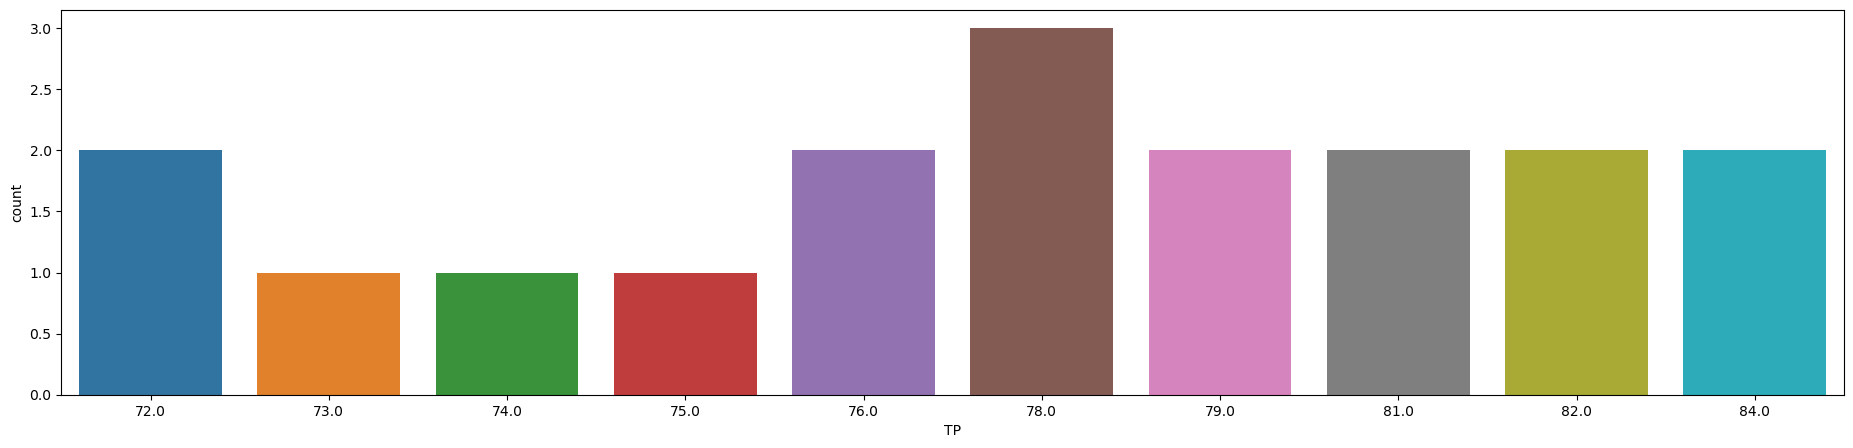

In [109]:
plt.figure(figsize=(23,5))
sns.countplot(data=score_df,x='TP')

<Axes: xlabel='FP', ylabel='count'>

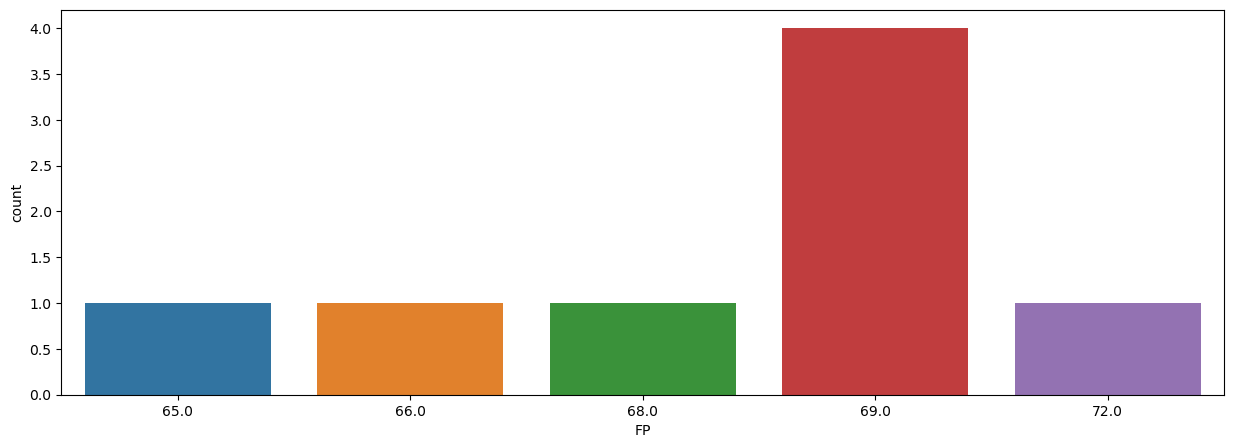

In [112]:
plt.figure(figsize=(15,5))
sns.countplot(data=score_df[score_df['TP'] > 78],x='FP')

In [113]:
score_df[(score_df['TP'] > 78) ]

,adaptive_th,mcv,edges,t,TP,FP,FN
0,2.5,20.0,1.5,0.50,84.0,69.0,61.0
1,2.6,20.0,1.5,0.50,79.0,66.0,66.0
3,2.5,20.0,2.0,0.50,81.0,72.0,64.0
4,2.6,20.0,2.0,0.50,79.0,68.0,66.0
6,2.5,20.0,1.5,0.75,82.0,69.0,63.0
9,2.5,20.0,2.0,0.75,84.0,69.0,61.0
12,2.5,20.0,1.5,1.00,81.0,65.0,64.0
15,2.5,20.0,2.0,1.00,82.0,69.0,63.0


In [174]:
total = 0
for row in random_list:
    total += len(get_gt(row))
total

50

# Evaluate

In [ ]:
def recall(tp, positive) -> float:
    return tp/positive
def prec(tp, fn) -> float:
    return tp/(tp + fn)

# Other

In [ ]:
# from scenedetect import detect, ContentDetector

# row = 0
# filename = df.loc[row,'Name']
# scene_list = detect(f'./videos - old/frame error/{filename}.mp4', ContentDetector(threshold=15,min_scene_len=1))
# for i, scene in enumerate(scene_list):
#     print('    Scene %2d: Start %s / Frame %d, End %s / Frame %d' % (
#         i+1,
#         scene[0].get_timecode(), scene[0].get_frames(),
#         scene[1].get_timecode(), scene[1].get_frames(),))

In [7]:
from skimage.feature import canny

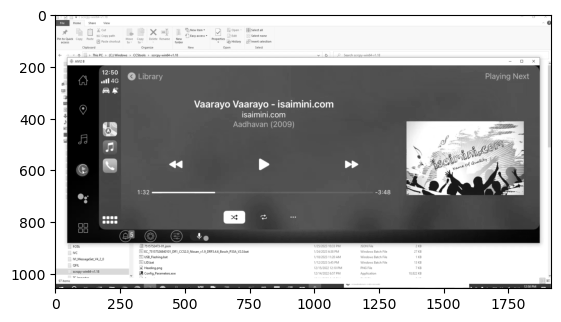

In [19]:
img = cv2.imread('./frames/frame error/AM-FM CP AM-FM/frame80_000003.jpg',0)
plt.imshow(img,cmap='gray')

In [20]:
canny_img = canny(img)
np.sum(canny_img)

80816

In [23]:
analyze_vid2 = pd.read_csv('stats.csv',header=0)
analyze_vid2.head()

,Frame Number,Timecode,adaptive_ratio (w=2),content_val,delta_edges,delta_hue,delta_lum,delta_sat
0,2,00:00:00.042,None,0.148137,0.369797,0.158457,0.094939,0.191014
1,3,00:00:00.083,1.4482130880521222,0.243551,0.721105,0.208005,0.173321,0.349326
2,4,00:00:00.125,1.5012958341332312,0.252018,0.166409,0.149369,0.179751,0.426935
3,5,00:00:00.167,1.494087119748247,0.272538,0.480737,0.165950,0.182796,0.468869
4,6,00:00:00.208,0.03825816816145882,0.007243,0.000000,0.017257,0.000701,0.003770


In [24]:
import seaborn as sns

<Axes: xlabel='Frame Number', ylabel='delta_edges'>

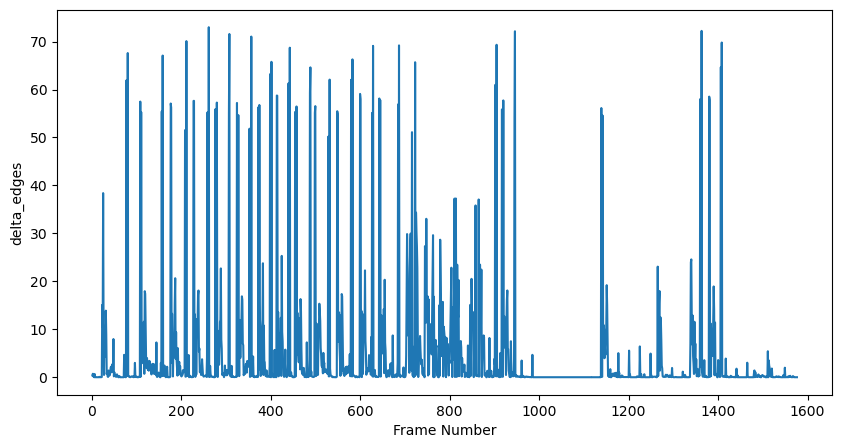

In [32]:
plt.figure(figsize=(10,5))
sns.lineplot(data=analyze_vid2,x='Frame Number',y='delta_edges')

In [43]:
l = [0]
l[1:]

[]